In [1]:
import os
import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import albumentations
from LookGenerator.networks.losses import PerceptualLoss, PerPixelLoss
from LookGenerator.datasets.encoder_decoder_datasets import GenerativeDatasetWithMask
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks.clothes_feature_extractor import ClothAutoencoder
from LookGenerator.networks.encoder_decoder import EncoderDecoder
from LookGenerator.networks_training.utils import check_path_and_creat
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks.utils import load_model
from LookGenerator.networks.utils import get_num_digits, save_model

# Загрузка данных

In [2]:
transform_human = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    #transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

transform_clothes = transforms.Compose([
    transforms.Resize((256, 192)),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 192)),
    custom_transforms.ThresholdTransform()
])

transform_human_restored = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    custom_transforms.MinMaxScale()
])

In [3]:
batch_size_train = 32
batch_size_val = 16
pin_memory = True
num_workers = 8

In [4]:
train_dataset = GenerativeDatasetWithMask(
    human_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\train\imageWithNoCloth",
    clothes_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\train\cloth",
    segmentation_mask_dir=r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize\train\agnostic-v3.3",
    human_restored_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\train\image",
    transform_human=transform_human,
    transform_clothes=transform_clothes,
    transform_mask=transform_mask,
    transform_human_restored=transform_human_restored
)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers
)

In [5]:
val_dataset = GenerativeDatasetWithMask(
    human_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\val\imageWithNoCloth",
    clothes_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\val\cloth",
    segmentation_mask_dir=r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize\test\agnostic-v3.3",
    human_restored_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\val\image",
    transform_human=transform_human,
    transform_clothes=transform_clothes,
    transform_mask=transform_mask,
    transform_human_restored=transform_human_restored
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers
)

In [6]:
for X, mask, y in train_dataloader:
    print(X.shape)
    print(mask.shape)
    print(y.shape)
    break

torch.Size([32, 6, 256, 192])
torch.Size([32, 1, 256, 192])
torch.Size([32, 3, 256, 192])


# Лосс

In [7]:
class EncoderDecoderWithMaskLoss(nn.Module):
    """
    Encoder-decoder custom loss
    """
    def __init__(self, device='cpu', weights=[1.0, 1.0, 1.0]):
        super(EncoderDecoderWithMaskLoss, self).__init__()
        self.perceptual_loss = PerceptualLoss(device, weights_perceptual=[1.0, 1.0, 1.0, 1.0])
        self.per_pixel_loss = PerPixelLoss().to(device)
        self.weights = weights

    def forward(self, outputs, mask, targets):
        perceptual = self.perceptual_loss(outputs, targets)
        per_pixel = self.per_pixel_loss(outputs, targets)
        outputs_masked = outputs*mask
        targets_masked = targets*mask
        per_pixel_masked = self.per_pixel_loss(outputs_masked, targets_masked)

        loss = (self.weights[0] * perceptual + self.weights[1] * per_pixel + self.weights[2] * per_pixel_masked) / sum(self.weights)

        return loss

# Обучение модели

In [8]:
clothes_feature_extractor = ClothAutoencoder(
    in_channels=3,
    out_channels=3,
    features=(8, 16, 32, 64),
    latent_dim_size=128,
    encoder_activation_func=nn.LeakyReLU(),
    decoder_activation_func=nn.ReLU()
)
clothes_feature_extractor = load_model(clothes_feature_extractor, r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\autoDegradation\weights\testClothes_L1Loss_4features\epoch_39.pt")

In [9]:
model = EncoderDecoder(clothes_feature_extractor, in_channels=6, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = EncoderDecoderWithMaskLoss(device=device, weights=[1.0, 0.0, 2.0])
print(device)

C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [10]:
save_directory=r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\newEncoder\weights\testWithMask_weights102"
check_path_and_creat(save_directory)

True

In [11]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [12]:
class TrainerWithMask:
    """
    Class for model training
    """
    def __init__(self, model_, optimizer, criterion, device='cpu', save_directory=r"", save_step=1, verbose=True):
        """

        Args:
            model_: model to train
            optimizer: model optimizer
            criterion: loss function for this model
            device: training device. Default: cpu
            save_directory: Path for this training session directory. Default: ""
            save_step: Step between epoch saves. Default: 1
            verbose: If 'True', will print verbose output of the model
        """
        self.model = model_
        self.optimizer = optimizer
        self.criterion = criterion
        device = torch.device(device)
        self.device = device
        self.criterion.to(self.device)

        self.train_history_epochs = []
        self.val_history_epochs = []

        self.train_history_batches = []
        self.val_history_batches = []

        self.save_directory = save_directory
        self.save_step = save_step
        self.verbose = verbose

    def train(self, train_dataloader, val_dataloader, epoch_num=5):
        """
        Train function
        Args:
            train_dataloader: dataloader for training
            val_dataloader: dataloader for validation
            epoch_num: number of epoch for training and validation
        """
        start = datetime.datetime.now()
        print("start time", start.strftime("%d-%m-%Y %H:%M"))

        for epoch in range(epoch_num):
            # Train
            train_loss = self._train_epoch(train_dataloader)
            self.train_history_epochs.append(train_loss)
            if self.verbose:
                print(f'Epoch {epoch} of {epoch_num - 1}, train loss: {train_loss:.5f}')
                now = datetime.datetime.now()
                print("Epoch end time", now.strftime("%d-%m-%Y %H:%M"))
            torch.cuda.empty_cache()

            # Validation
            val_loss = self._val_epoch(val_dataloader)
            self.val_history_epochs.append(val_loss)
            if self.verbose:
                print(f'Epoch {epoch} of {epoch_num - 1}, val loss: {val_loss:.5f}')
                now = datetime.datetime.now()
                print("Epoch end time", now.strftime("%d-%m-%Y %H:%M"))
            torch.cuda.empty_cache()

            # Save
            if self.save_step == 0 or self.save_directory == "":
                continue
            if (epoch + 1) % self.save_step == 0:
                save_model(self.model.to('cpu'), path=f"{self.save_directory}\\epoch_{self._epoch_string(epoch, epoch_num)}.pt")

        now = datetime.datetime.now()
        print("end time", now.strftime("%d-%m-%Y %H:%M"))
        print("delta", now - start)

    def _train_epoch(self, train_dataloader):
        """
        Method for epoch training
        Args:
            train_dataloader:  train dataloader

        Returns: train loss

        """
        self.model = self.model.to(self.device)

        train_running_loss = 0.0
        self.model.train()
        for data, mask, targets in tqdm(train_dataloader):
            data = data.to(self.device)
            mask = mask.to(self.device)
            targets = targets.to(self.device)
            outputs = self.model(data)

            self.optimizer.zero_grad()
            loss = self.criterion(outputs, mask, targets)
            loss.backward()
            self.optimizer.step()

            loss_number = loss.item()
            train_running_loss += loss_number
            self.train_history_batches.append(loss_number)

        train_loss = train_running_loss / len(train_dataloader)
        return train_loss

    def _val_epoch(self, val_dataloader):
        """
        Method for epoch validation
        Args:
            val_dataloader:

        Returns: validation loss

        """
        val_running_loss = 0.0
        self.model.eval()
        for data, mask, targets in tqdm(val_dataloader):
            data = data.to(self.device)
            mask = mask.to(self.device)
            targets = targets.to(self.device)
            outputs = self.model(data)

            loss = self.criterion(outputs, mask, targets)
            loss_number = loss.item()
            val_running_loss += loss_number
            self.val_history_batches.append(loss_number)

        val_loss = val_running_loss / len(val_dataloader)
        return val_loss

    @staticmethod
    def _epoch_string(epoch, epoch_num):
        """
        Method to create a string form of current epoch number, using the same number
        of digits for every training session

        Args:
            epoch: number of current epoch
            epoch_num: number of epochs for this training session

        Returns: converted to string epoch number

        """
        num_digits_epoch_num = get_num_digits(epoch_num)
        num_digits_epoch = get_num_digits(epoch)

        epoch_string = "0"*(num_digits_epoch_num - num_digits_epoch) + str(epoch)
        return epoch_string

    def draw_history_plots(self, epochs=True):
        """
        Draws plots of train and validation

        Args:
            epochs: TODO: if 'True', draws history plots by epochs, else by batches
        """
        if epochs:
            plt.plot(self.train_history_epochs, label="train")
            plt.plot(self.val_history_epochs, label="val")
            plt.show()
        else:
            plt.plot(self.train_history_batches, label="train")
            plt.plot(self.val_history_batches, label="val")
            plt.show()

    def __str__(self):
        description = f"Model:\n\t{str(self.model)}\n" \
                      f"Criterion: \n\t{str(type(self.criterion))}\n" \
                      f"Optimizer: \n\t{str(type(self.optimizer))}"
        return description

In [13]:
trainer = TrainerWithMask(
    model_=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_directory=save_directory,
    save_step=1,
    verbose=True
)

In [14]:
trainer.train(train_dataloader, val_dataloader, epoch_num=20)

start time 31-05-2023 16:16


  0%|          | 0/364 [00:00<?, ?it/s]C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 364/364 [05:01<00:00,  1.21it/s]


Epoch 0 of 19, train loss: 1.16997
Epoch end time 31-05-2023 16:21


100%|██████████| 127/127 [00:26<00:00,  4.83it/s]


Epoch 0 of 19, val loss: 0.93826
Epoch end time 31-05-2023 16:22


100%|██████████| 364/364 [03:34<00:00,  1.69it/s]


Epoch 1 of 19, train loss: 0.84462
Epoch end time 31-05-2023 16:25


100%|██████████| 127/127 [00:26<00:00,  4.84it/s]


Epoch 1 of 19, val loss: 1.16152
Epoch end time 31-05-2023 16:26


100%|██████████| 364/364 [03:09<00:00,  1.92it/s]


Epoch 2 of 19, train loss: 0.78803
Epoch end time 31-05-2023 16:29


100%|██████████| 127/127 [00:26<00:00,  4.81it/s]


Epoch 2 of 19, val loss: 1.09169
Epoch end time 31-05-2023 16:29


100%|██████████| 364/364 [03:48<00:00,  1.59it/s]


Epoch 3 of 19, train loss: 0.75763
Epoch end time 31-05-2023 16:33


100%|██████████| 127/127 [00:25<00:00,  4.94it/s]


Epoch 3 of 19, val loss: 0.94409
Epoch end time 31-05-2023 16:34


100%|██████████| 364/364 [03:18<00:00,  1.83it/s]


Epoch 4 of 19, train loss: 0.73223
Epoch end time 31-05-2023 16:37


100%|██████████| 127/127 [00:25<00:00,  4.89it/s]


Epoch 4 of 19, val loss: 0.80825
Epoch end time 31-05-2023 16:37


100%|██████████| 364/364 [03:14<00:00,  1.88it/s]


Epoch 5 of 19, train loss: 0.71455
Epoch end time 31-05-2023 16:40


100%|██████████| 127/127 [00:25<00:00,  4.95it/s]


Epoch 5 of 19, val loss: 0.78251
Epoch end time 31-05-2023 16:41


100%|██████████| 364/364 [03:09<00:00,  1.92it/s]


Epoch 6 of 19, train loss: 0.69914
Epoch end time 31-05-2023 16:44


100%|██████████| 127/127 [00:25<00:00,  5.04it/s]


Epoch 6 of 19, val loss: 0.83013
Epoch end time 31-05-2023 16:45


100%|██████████| 364/364 [03:06<00:00,  1.95it/s]


Epoch 7 of 19, train loss: 0.68537
Epoch end time 31-05-2023 16:48


100%|██████████| 127/127 [00:25<00:00,  5.04it/s]


Epoch 7 of 19, val loss: 0.74131
Epoch end time 31-05-2023 16:48


100%|██████████| 364/364 [02:39<00:00,  2.28it/s]


Epoch 8 of 19, train loss: 0.67277
Epoch end time 31-05-2023 16:51


100%|██████████| 127/127 [00:25<00:00,  5.06it/s]


Epoch 8 of 19, val loss: 1.01580
Epoch end time 31-05-2023 16:51


100%|██████████| 364/364 [02:42<00:00,  2.24it/s]


Epoch 9 of 19, train loss: 0.66185
Epoch end time 31-05-2023 16:54


100%|██████████| 127/127 [00:24<00:00,  5.14it/s]


Epoch 9 of 19, val loss: 0.75131
Epoch end time 31-05-2023 16:54


100%|██████████| 364/364 [02:30<00:00,  2.42it/s]


Epoch 10 of 19, train loss: 0.65037
Epoch end time 31-05-2023 16:57


100%|██████████| 127/127 [00:25<00:00,  5.05it/s]


Epoch 10 of 19, val loss: 0.72051
Epoch end time 31-05-2023 16:57


100%|██████████| 364/364 [02:43<00:00,  2.23it/s]


Epoch 11 of 19, train loss: 0.63833
Epoch end time 31-05-2023 17:00


100%|██████████| 127/127 [00:24<00:00,  5.14it/s]


Epoch 11 of 19, val loss: 0.89782
Epoch end time 31-05-2023 17:00


100%|██████████| 364/364 [04:34<00:00,  1.33it/s]


Epoch 12 of 19, train loss: 0.62635
Epoch end time 31-05-2023 17:05


100%|██████████| 127/127 [00:27<00:00,  4.64it/s]


Epoch 12 of 19, val loss: 0.75062
Epoch end time 31-05-2023 17:05


100%|██████████| 364/364 [03:48<00:00,  1.59it/s]


Epoch 13 of 19, train loss: 0.61465
Epoch end time 31-05-2023 17:09


100%|██████████| 127/127 [00:25<00:00,  4.89it/s]


Epoch 13 of 19, val loss: 0.75057
Epoch end time 31-05-2023 17:10


100%|██████████| 364/364 [04:03<00:00,  1.50it/s]


Epoch 14 of 19, train loss: 0.60352
Epoch end time 31-05-2023 17:14


100%|██████████| 127/127 [00:27<00:00,  4.67it/s]


Epoch 14 of 19, val loss: 0.96760
Epoch end time 31-05-2023 17:14


100%|██████████| 364/364 [03:46<00:00,  1.60it/s]


Epoch 15 of 19, train loss: 0.59112
Epoch end time 31-05-2023 17:18


100%|██████████| 127/127 [00:26<00:00,  4.83it/s]


Epoch 15 of 19, val loss: 0.71714
Epoch end time 31-05-2023 17:18


100%|██████████| 364/364 [03:30<00:00,  1.73it/s]


Epoch 16 of 19, train loss: 0.58229
Epoch end time 31-05-2023 17:22


100%|██████████| 127/127 [00:28<00:00,  4.44it/s]


Epoch 16 of 19, val loss: 0.89230
Epoch end time 31-05-2023 17:22


100%|██████████| 364/364 [02:56<00:00,  2.07it/s]


Epoch 17 of 19, train loss: 0.56890
Epoch end time 31-05-2023 17:25


100%|██████████| 127/127 [00:26<00:00,  4.88it/s]


Epoch 17 of 19, val loss: 0.74742
Epoch end time 31-05-2023 17:26


100%|██████████| 364/364 [03:00<00:00,  2.02it/s]


Epoch 18 of 19, train loss: 0.55883
Epoch end time 31-05-2023 17:29


100%|██████████| 127/127 [00:26<00:00,  4.76it/s]


Epoch 18 of 19, val loss: 0.70740
Epoch end time 31-05-2023 17:29


100%|██████████| 364/364 [03:38<00:00,  1.67it/s]


Epoch 19 of 19, train loss: 0.54776
Epoch end time 31-05-2023 17:33


100%|██████████| 127/127 [00:26<00:00,  4.76it/s]

Epoch 19 of 19, val loss: 0.97280
Epoch end time 31-05-2023 17:33
end time 31-05-2023 17:33
delta 1:17:02.951698


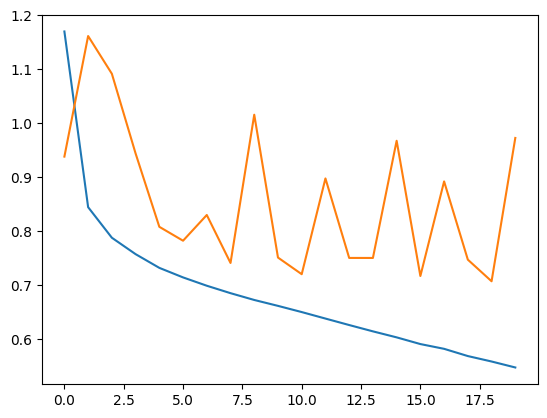

In [15]:
trainer.draw_history_plots()

In [16]:
print(str(trainer))

Model:
	Encoder-decoder: 
	base model 
Autoencoder: 
	features: (8, 16, 32, 64), latent_size: 128
Criterion: 
	<class '__main__.EncoderDecoderWithMaskLoss'>
Optimizer: 
	<class 'torch.optim.adam.Adam'>


In [17]:
file = open(os.path.join(save_directory, "readme.txt"), 'w')
file.write(str(trainer))
file.close()